In [1]:
from exact_coeffs import interpolation_coeffs
import numpy as np
import aesara.tensor as at
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

from ringdb import Database
import ringdown

db = Database('./Data')
db.initialize()

db.update_posterior_schema({'f_low': {'path': "/{approximant}/meta_data/meta_data/f_low", 'type':'value'}})
db.update_posterior_schema({'f_ref': {'path': "/{approximant}/meta_data/meta_data/f_ref", 'type':'value'}})

In [35]:
def get_target(eventname, N_samps=None, target_sample_rate=4096, f_low=20, f_ref=20, q=0.5, maximum_likelihood=False):
    event = db.event(eventname)
    strains = event.strain()
    posts = event.posteriors()

    N_samps = N_samps or len(posts)

    try:
        f_low = float(event.read_posterior_file_from_schema('f_low'))
        f_ref = float(event.read_posterior_file_from_schema('f_ref'))
        waveform_name = posts['waveform_name'].unique()[0]
        waveform_code = int(posts['waveform_code'].unique()[0])
    except:
        print("Falling back to f_ref = 20, f_low=20")
        waveform_name = posts['waveform_name'].unique()[0]
        waveform_code = int(posts['waveform_code'].unique()[0])
        f_low = f_low
        f_ref = f_ref


    print(f"Using {waveform_name}")
    wf_ls = waveform_code
    sample_rate = np.max([a.fsamp for a in strains.values()])

    samps = [x.to_dict() for i,x in posts.sample(N_samps).iterrows()]

    for i,x in enumerate(samps):
        t_peak, t_dict, hp, hc = ringdown.complex_strain_peak_time_td(x,
                                                                      wf=wf_ls, dt=1/target_sample_rate,
                                                                      f_ref=f_ref, f_low=f_low)
        samps[i].update({k+'_peak':v for k,v in t_dict.items()})

    samps = pd.DataFrame(samps)

    # Get median sample
    ref_ifo = 'H1'
    if maximum_likelihood:
        im = samps['log_likelihood'].argmax()
    else:
        im = (samps[f'{ref_ifo}_peak'] - samps[f'{ref_ifo}_peak'].quantile(q)).abs().argmin()
    median_samp = samps.iloc[im]

    # Construct Arguments for set_target
    args = median_samp[['geocent_peak', 'ra','dec','psi']].rename({'geocent_peak':'t0'}).to_dict()
    print("The median time at H1 is: ", median_samp['H1_peak'], "s")

    # Get the mass time-scale
    Mass_Time = lambda M: 6.674e-11*M*1.989e+30/(3e8)**3
    t_M = Mass_Time(median_samp['final_mass'])
    print("The mass time-scale is: ", np.round(t_M*1000,3), "ms")

    times_above_below = (samps['H1_peak'].quantile(0.95) - samps['H1_peak'].quantile(0.05))/(2*t_M)
    print(f"The 90% CI of H1 peak time is +/- {np.round(times_above_below,1)} t_M")

    return args, median_samp, samps


def set_fit(eventname, target, mass_for_prior, duration=0.1, target_sample_rate=4096, model='mchi', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)], **model_kwargs):
    event = db.event(eventname)
    strains = event.strain()
    
    fit = ringdown.Fit(model=model, modes=modes, **model_kwargs)
    
    for ifo in strains.keys():
        fit.add_data(strains[ifo])
        
    sample_rate = np.max([f.fsamp for f in strains.values()])

    fit.set_target(**target, duration=duration)
    fit.condition_data(ds=int(sample_rate/target_sample_rate),digital_filter=True,flow=20)
    fit.compute_acfs()

    fit.update_prior(A_scale=5e-21, M_min=mass_for_prior*0.5,
                     M_max=mass_for_prior*2.0,
                     flat_A=1)
    return fit

def combined_results(fit_result, posts):
    cols = [(r'$M$','M'), (r'$\chi$','chi')]
    the_result = pd.DataFrame({col[0]: fit_result['posterior'][col[1]].values.flatten() for col in cols})
    the_result['result'] = 'Ringdown'

    cols = [(r'$M$','final_mass'), (r'$\chi$','final_spin')]
    the_result2 = pd.DataFrame({col[0]: posts[col[1]].values.flatten() for col in cols})
    the_result2['result'] = 'IMR'

    the_result = pd.concat([the_result, the_result2]).reset_index(drop=True)
    return the_result


def Make_Plots(result, posts, eventname, chain=[0,1,2,3]):
    result = result.sel(chain=chain)
    M_chi = combined_results(result, posts)
    result = result['posterior']
    g = sns.jointplot(data=M_chi, x=r'$M$', y=r'$\chi$', hue='result', 
              kind='kde', fill=True, levels=[0.3,0.6,0.9], common_norm=False, alpha=0.7)

    g.fig.suptitle(f"{eventname} M vs "+r"$\chi$")
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    plt.show()
    
    chi_Q = pd.DataFrame({r'$Q$': result['Q_charge'].values.flatten(),
              r'$\chi$': result['chi'].values.flatten()})

    g = sns.jointplot(data=chi_Q, y=r'$\chi$', x=r'$Q$', 
                  kind='hex')
    x = np.linspace(0,1,100)
    g.ax_joint.plot(x, np.sqrt(1-x**2))
    g.ax_joint.set_xlim((0,1))
    g.ax_joint.set_ylim((0,1))
    g.fig.suptitle(f"{eventname} Q vs"+r"$\chi$" + " hexbin")
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    plt.show()
    
    
    g = sns.jointplot(data=chi_Q, y=r'$\chi$', x=r'$Q$', 
              kind='kde', levels=[0.3,0.6,0.9], fill=True, alpha=0.7)
    x = np.linspace(0,1,100)
    g.ax_joint.plot(x, np.sqrt(1-x**2))
    g.ax_joint.set_xlim((0,1))
    g.ax_joint.set_ylim((0,1))
    g.ax_joint.plot(chi_Q[r'$Q$'].median(),chi_Q[r'$\chi$'].median(),'+',c='k')
    g.fig.suptitle(f"{eventname} charged run")
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    
    
    pts = np.array([chi_Q[r'$Q$'], chi_Q[r'$\chi$']])
    fig, ax = plt.subplots(1,figsize=(6,6))
    Bounded_KDE_Plot_Quadrant(pts, ax=ax, title="Bounded KDE constraints\n for GW150914")
    plt.show()

def Make_Plots_uncharged(result, posts, eventname, chain=[0,1,2,3]):
    result = result.sel(chain=chain)
    M_chi = combined_results(result, posts)
    result = result['posterior']
    g = sns.jointplot(data=M_chi, x=r'$M$', y=r'$\chi$', hue='result', 
              kind='kde', fill=True, common_norm=False, alpha=0.7)

    g.fig.suptitle(f"{eventname} M vs "+r"$\chi$")
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    plt.show()


    
    
def kdeplot_2d_clevels_return(xs, ys, levels=11, **kwargs):
    try:
        xs = xs.values.astype(float)
        ys = ys.values.astype(float)
    except AttributeError:
        pass
    
    try:
        len(levels)
        f = 1 - np.array(levels)
    except TypeError:
        f = linspace(0, 1, levels+2)[1:-1]
    if kwargs.get('auto_bound', False):
        kwargs['xlow'] = min(xs)
        kwargs['xhigh'] = max(xs)
        kwargs['ylow'] = min(ys)
        kwargs['yhigh'] = max(ys)
    kde_kws = {k: kwargs.pop(k, None) for k in ['xlow', 'xhigh', 'ylow', 'yhigh']}
    k = ringdown.Bounded_2d_kde(np.column_stack((xs, ys)), **kde_kws)
    size = max(10*(len(f)+2), 500)
    c = np.random.choice(len(xs), size=size)
    p = k(np.column_stack((xs[c], ys[c])))
    i = np.argsort(p)
    l = np.array([p[i[int(round(ff*len(i)))]] for ff in f])

    x = np.linspace(0, 1, 128)
    y = np.linspace(0, np.pi/2, 128)

    XS, YS = np.meshgrid(x, y, indexing='ij')
    ZS = k(np.column_stack((XS.flatten(), YS.flatten()))).reshape(XS.shape)
    
    return XS, YS, ZS, l

def Bounded_KDE_Plot_Quadrant(pts, levels=[0.3,0.6,0.9],ax=None, title=None):
    rtheta = np.array([np.array([np.sqrt(a[0]**2 + a[1]**2), np.arctan(a[1]/a[0])]) for a in pts.transpose()])
    kde = ringdown.Bounded_2d_kde(rtheta, xlow=0.0, xhigh=1.0, ylow=0.0, yhigh=np.pi/2)

    RS, ThetaS, ZS, l = kdeplot_2d_clevels_return(rtheta[:,0], rtheta[:,1], levels=levels)


    XS = np.array([[RS[i,j]*np.cos(ThetaS[i,j]) for i in range(RS.shape[0])] for j in range(RS.shape[1])])
    YS = np.array([[RS[i,j]*np.sin(ThetaS[i,j]) for i in range(RS.shape[0])] for j in range(RS.shape[1])])
    ZS = np.array([[ZS[i,j] for i in range(RS.shape[0])] for j in range(RS.shape[1])])

    if ax is None:
        fig, ax = plt.subplots(1, figsize=(5,5))
    ax.contourf(XS, YS, ZS, levels=[l[-i-1] for i in range(len(l))], alpha=0.5)
    t = np.linspace(0,1,100)
    ax.plot(t, np.sqrt(1-t**2))
    ax.set_aspect(1)
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    ax.set_xlabel(r"$Q$")
    ax.set_ylabel(r"$\chi$")
    ax.plot(np.median(pts[0,:]),np.median(pts[1,:]),'+',c='k')
    ax.set_title(title or "Attempt at Bounded KDE for charged result")
    return ax

## Full Example Run in three cells

In [ ]:
eventname = 'GW150914'
event = db.event(eventname)

args, median_samp, samps = get_target('GW150914', N_samps=800, q=0.5)
fit = set_fit('GW150914', args, median_samp['final_mass'])

fit.run()

/Users/asadh/Documents/GitHub/ringdb_test_venv/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  warnings.warn(


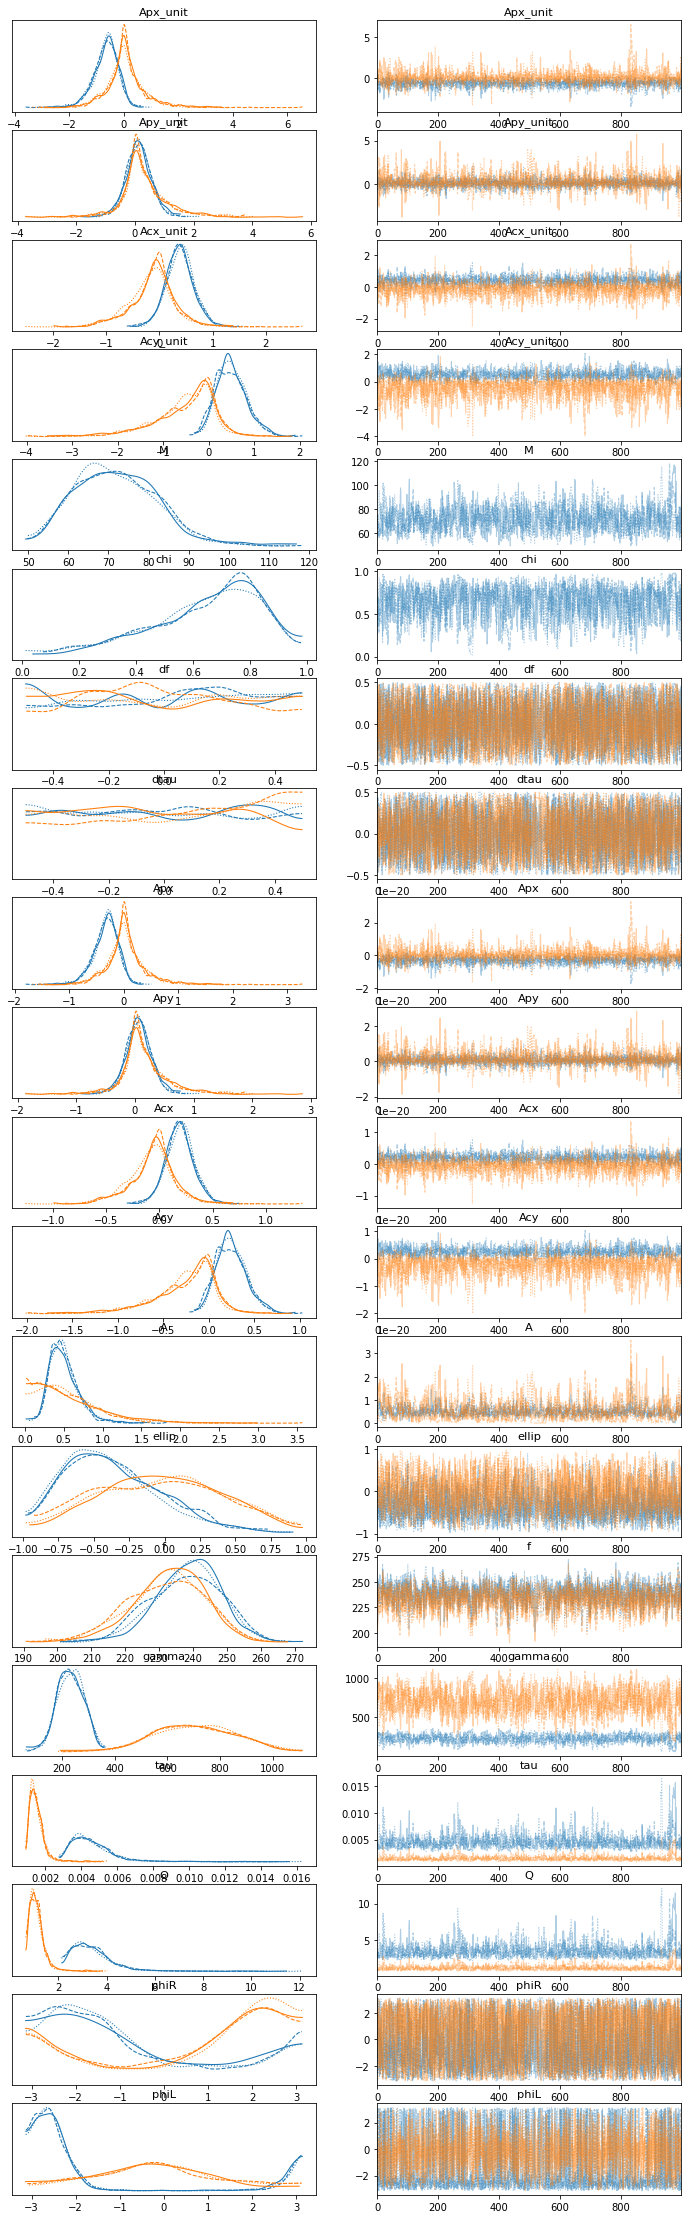

In [17]:
## Check if all chains are good
az.plot_trace(fit.result.sel(chain=[0,1,2]))
plt.show()

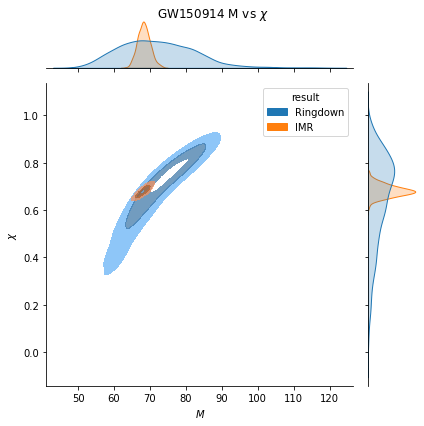

In [16]:
Make_Plots_uncharged(fit.result, posts=event.posteriors().sample(800), eventname=eventname,  chain=[0,1,2])

## Charged Run

In [18]:
eventname = 'GW150914'
event = db.event(eventname)

args, median_samp, samps = get_target('GW150914', N_samps=800, q=0.5)
fit_charged = set_fit('GW150914', args, median_samp['final_mass'], model='mchiq_exact', **interpolation_coeffs)

fit_charged.run()

Falling back to f_ref = 20, f_low=20
Using IMRPhenomPv2
The median time at H1 is:  1126259462.4235818 s
The mass time-scale is:  0.346 ms
The 90% CI of H1 peak time is +/- 2.8 t_M


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, r2_qchi, theta_qchi, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, r2_qchi, theta_qchi, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 407 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 407 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/Users/asadh/Documents/GitHub/ringdb_test_venv/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (26), generating only 20 plots
  warnings.warn(


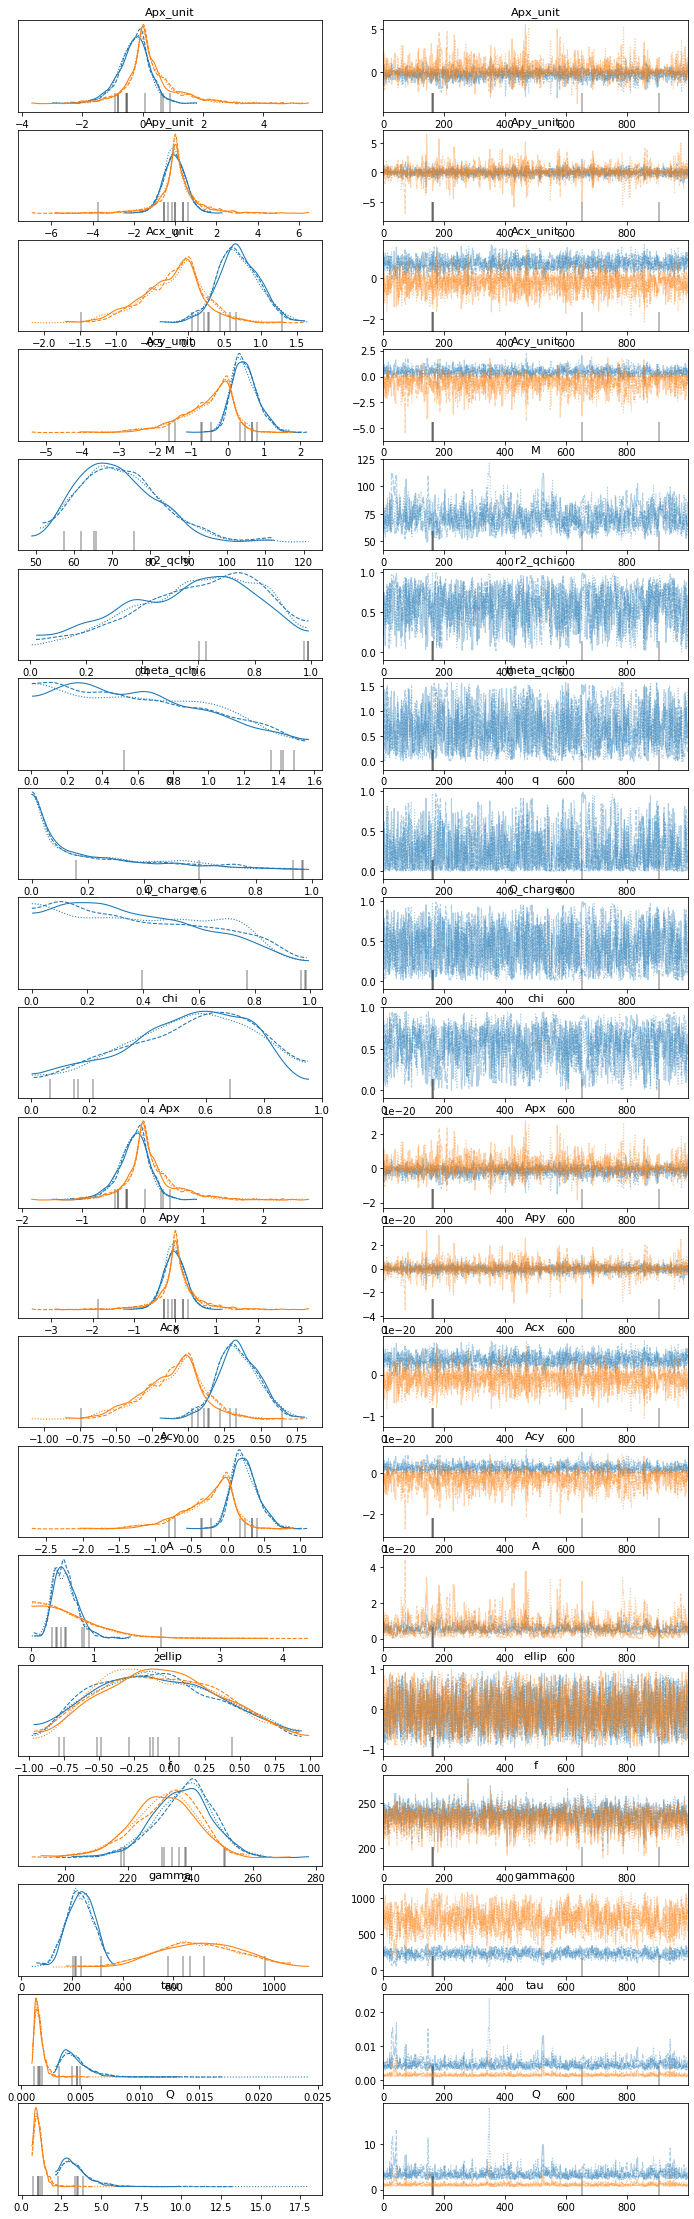

In [22]:
## Check if all chains are good
az.plot_trace(fit_charged.result.sel(chain=[0,1,3]))
plt.show()

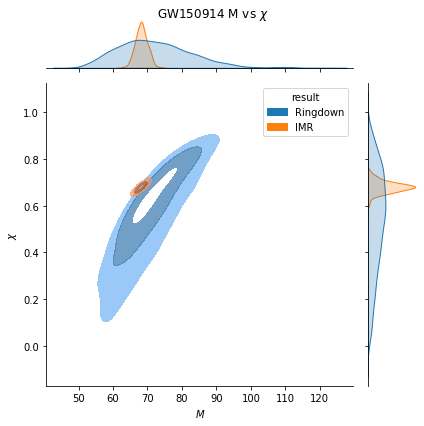

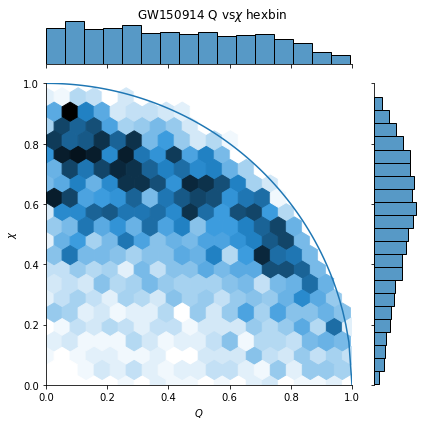

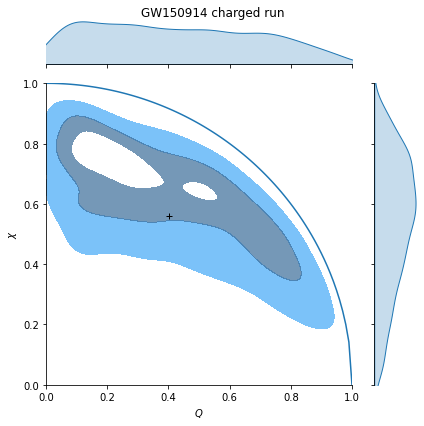

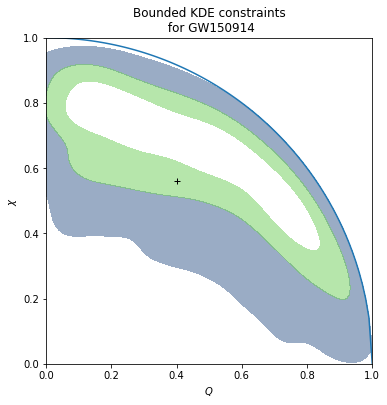

In [38]:
Make_Plots(fit_charged.result, posts=event.posteriors().sample(800), eventname=eventname,  chain=[0,1,3])

### Lets try 190521

In [38]:
event = db.event('GW190521')

args, median_samp, samps = get_target('GW190521', N_samps=800, q=0.5, maximum_likelihood=False)
#args = dict(t0 = 1242459857.4579797, ra = 5.3752997, dec = 0.56443977, psi = 2.0679284)
fit = set_fit('GW190521', args, median_samp['final_mass'])

fit.run()

Using IMRPhenomPv3HM
The median time at H1 is:  1242442967.4275403 s
The mass time-scale is:  1.169 ms
The 90% CI of H1 peak time is +/- 5.6 t_M


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]
INFO:pymc:NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.


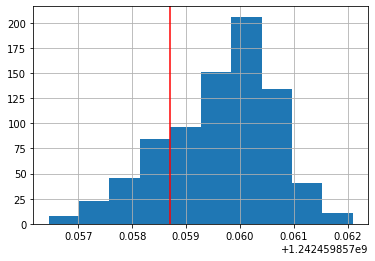

In [71]:
samps['H1_peak'].hist()
plt.axvline(median_samp['H1_peak'],c='r')

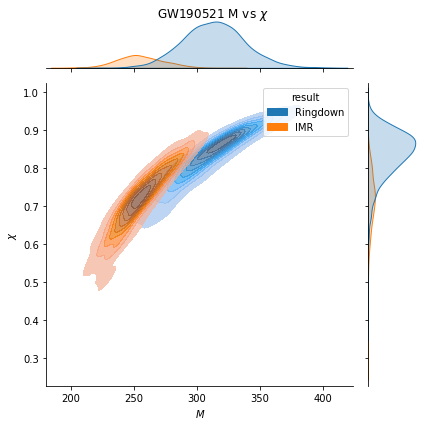

In [39]:
Make_Plots_uncharged(fit.result, event.posteriors().sample(800),'GW190521')

In [ ]:
ringdown.model.chi_factors(0.1)

In [40]:
az.summary(fit.result, var_names=['M','chi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M,313.528,24.801,266.131,358.738,0.497,0.360,2613.0,2036.0,1.0
chi,0.835,0.065,0.712,0.938,0.001,0.001,2695.0,1981.0,1.0


In [81]:
[a for a in event.posteriors().columns if 'mass' in a ]

['mass_ratio',
 'chirp_mass',
 'inverted_mass_ratio',
 'mass_1',
 'mass_2',
 'total_mass',
 'symmetric_mass_ratio',
 'final_mass_non_evolved',
 'final_mass_source_non_evolved',
 'final_mass',
 'final_mass_source',
 'mass_1_source',
 'mass_2_source',
 'total_mass_source',
 'chirp_mass_source']

/Users/asadh/Documents/GitHub/ringdb_test_venv/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'Apx_unit'}>,
        <AxesSubplot:title={'center':'Apx_unit'}>],
       [<AxesSubplot:title={'center':'Apy_unit'}>,
        <AxesSubplot:title={'center':'Apy_unit'}>],
       [<AxesSubplot:title={'center':'Acx_unit'}>,
        <AxesSubplot:title={'center':'Acx_unit'}>],
       [<AxesSubplot:title={'center':'Acy_unit'}>,
        <AxesSubplot:title={'center':'Acy_unit'}>],
       [<AxesSubplot:title={'center':'M'}>,
        <AxesSubplot:title={'center':'M'}>],
       [<AxesSubplot:title={'center':'chi'}>,
        <AxesSubplot:title={'center':'chi'}>],
       [<AxesSubplot:title={'center':'df'}>,
        <AxesSubplot:title={'center':'df'}>],
       [<AxesSubplot:title={'center':'dtau'}>,
        <AxesSubplot:title={'center':'dtau'}>],
       [<AxesSubplot:title={'center':'Apx'}>,
        <AxesSubplot:title={'center':'Apx'}>],
       [<AxesSubplot:title={'center':'Apy'}>,
        <AxesSubplot:title={'center':'Apy'}>],
       [<AxesSubplot:title={'cente

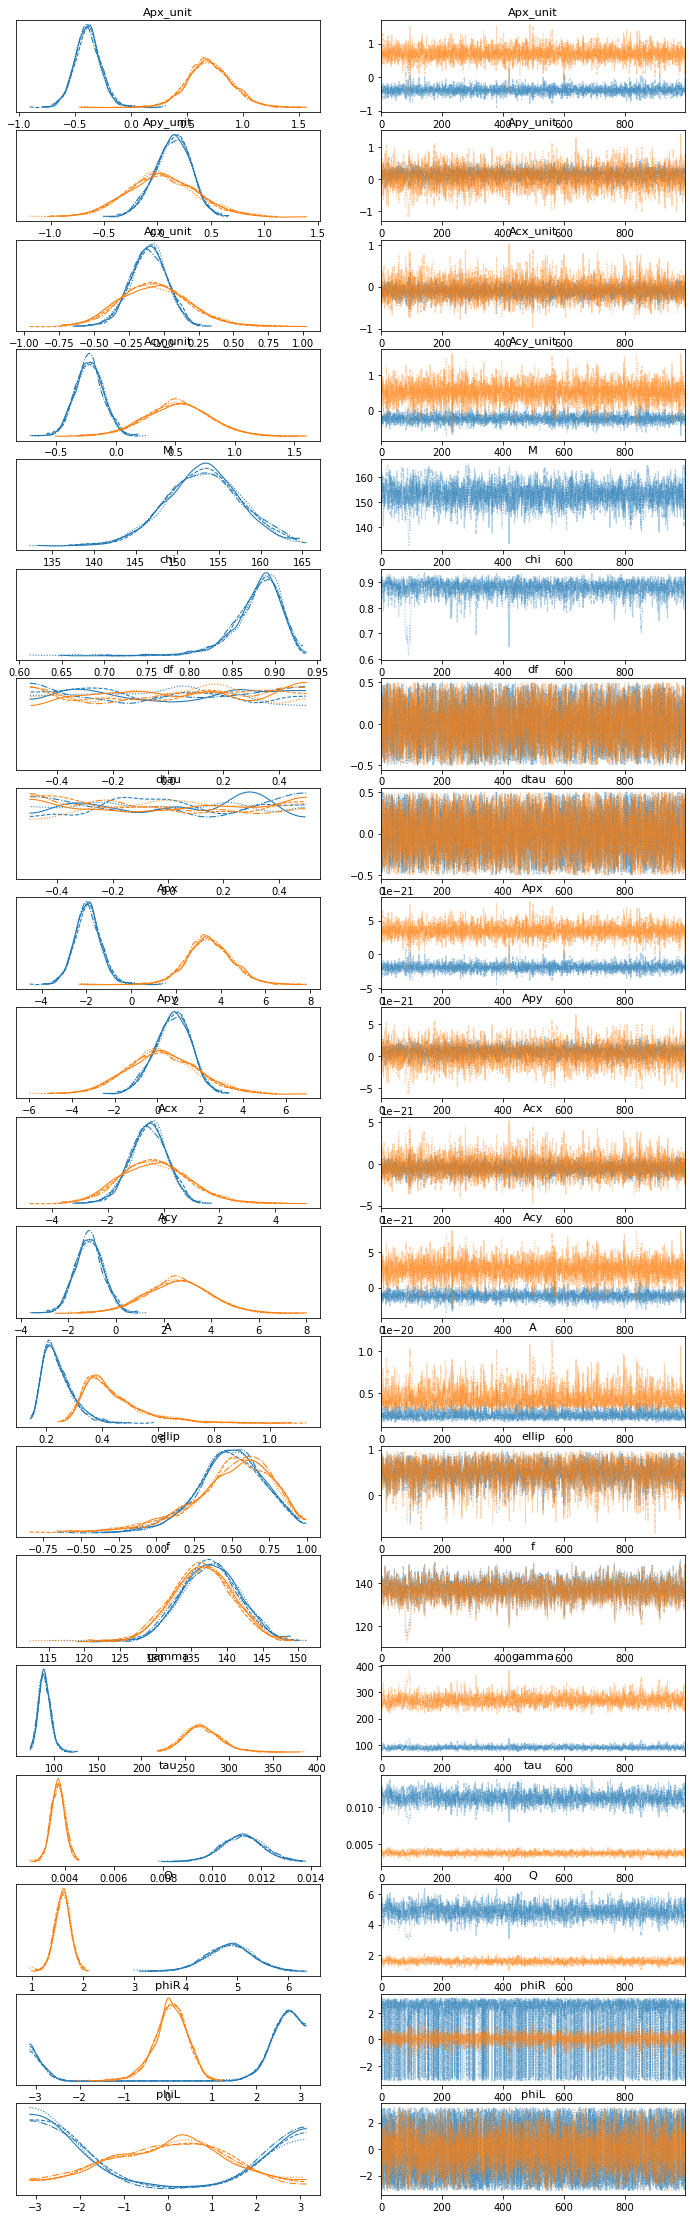

In [86]:
az.plot_trace(fit.result)

In [12]:
event.posteriors()

,H1_matched_filter_abs_snr,H1_matched_filter_snr_angle,H1_optimal_snr,H1_spcal_amp_0,H1_spcal_amp_1,H1_spcal_amp_2,H1_spcal_amp_3,H1_spcal_amp_4,H1_spcal_amp_5,H1_spcal_amp_6,...,L1_time,V1_time,H1_matched_filter_snr,L1_matched_filter_snr,V1_matched_filter_snr,cos_theta_jn,cos_iota,peak_luminosity,waveform_name,waveform_code
0,8.112519,0.119225,8.303043,0.006133,0.015274,-0.009832,-0.007920,0.012304,-0.012303,0.006214,...,1.242443e+09,1.242443e+09,8.054929,11.700585,1.893895,-0.697530,-0.498645,3.677521,IMRPhenomPv3HM,99
1,8.022418,-0.029685,7.285320,-0.011282,-0.062583,-0.039128,0.003292,0.005657,-0.004694,-0.002613,...,1.242443e+09,1.242443e+09,8.018884,11.704069,1.906365,-0.989915,-0.920805,3.411771,IMRPhenomPv3HM,99
2,7.752792,-0.037184,7.163068,0.000213,-0.022019,-0.007959,-0.004364,0.034782,-0.022168,0.009446,...,1.242443e+09,1.242443e+09,7.747433,11.647492,2.088734,-0.776199,-0.822570,2.917285,IMRPhenomPv3HM,99
3,8.138242,0.110371,6.558107,0.001714,0.025636,-0.021009,-0.028393,0.003203,-0.006229,0.013003,...,1.242443e+09,1.242443e+09,8.088723,11.768621,1.884292,-0.681327,-0.590308,3.336923,IMRPhenomPv3HM,99
4,7.638002,-0.320711,7.122225,-0.037455,-0.013627,-0.009326,0.007029,-0.011209,-0.004561,0.004806,...,1.242443e+09,1.242443e+09,7.248551,11.643816,1.397216,-0.703176,-0.600718,3.638978,IMRPhenomPv3HM,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49258,7.980034,0.175842,7.139329,0.005481,0.014831,0.001867,-0.013116,0.025967,0.000086,0.005561,...,1.242443e+09,1.242443e+09,7.856978,11.739178,3.031443,-0.788301,-0.692579,4.114989,IMRPhenomPv3HM,99
49259,7.935920,-0.122013,6.921407,0.044083,-0.006260,-0.062433,-0.025213,0.030592,-0.004624,0.001645,...,1.242443e+09,1.242443e+09,7.876922,11.715819,3.099421,-0.862998,-0.781434,4.197545,IMRPhenomPv3HM,99
49260,7.968522,0.087306,7.639947,0.031591,0.015878,-0.029676,-0.023265,0.003649,-0.006243,-0.017714,...,1.242443e+09,1.242443e+09,7.938172,11.908660,2.065344,-0.398489,-0.127424,3.864979,IMRPhenomPv3HM,99
49261,8.052982,-0.046748,7.091614,-0.040130,-0.001767,-0.028286,-0.018189,-0.031471,0.017564,-0.006183,...,1.242443e+09,1.242443e+09,8.044184,11.569197,1.960652,0.947350,0.940284,3.748649,IMRPhenomPv3HM,99


In [30]:
fit.to_config(path="asad.ini")

In [31]:
!pwd

/Users/asadh/Documents/GitHub/charged-ringdown-analysis-tools/charged_analysis


In [51]:
fit.inject(**median_samp)

KeyError: 'omega'

In [49]:
ringdown.waveforms.Parameters.construct(**median_samp)

Parameters(mass_1=136.38180234680914, mass_2=111.41144628493035, spin_1x=0.2394205771763273, spin_1y=0.8189434813284895, spin_1z=-0.22230069041024583, spin_2x=-0.16446888389926076, spin_2y=-0.40239959646086937, spin_2z=-0.48964937596661817, luminosity_distance=4056.3898265178145, iota=0.7401072375570517, phase=2.4594961321582143, long_asc_nodes=0.0, eccentricity=0.0, mean_per_ano=0.0, f_low=20.0, f_ref=None, psi=3.1404837143286772, ra=3.3971822193745753, dec=0.5142309592005405, trigger_time=1242442967.464296)

In [60]:
t_peak = args['t0']
waveform_model = median_samp['waveform_name']
wv = ringdown.Coalescence.from_parameters(time=np.linspace(t_peak-0.05, t_peak+0.05, int(0.1*2**14)),
                                          model=waveform_model,f_ref=20.0,
                                          f_low=20.0,manual_epoch = False,window=0.0, 
                                          **median_samp.to_dict())

In [67]:
wv.get_parameter()

TypeError: get_parameter() missing 1 required positional argument: 'k'